<a href="https://colab.research.google.com/github/CameronBannick/Uap_prediction/blob/main/project_2_part_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data Cleaning

In [62]:
#importing libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
set_config(display='diagram')


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import data
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo/Week 7/Data Proposals/nuforc_reports.csv')
df.head()

,summary,city,state,date_time,shape,duration,stats,report_link,text,posted,city_latitude,city_longitude
0,My wife was driving southeast on a fairly popu...,Chester,VA,2019-12-12T18:43:00,light,5 seconds,Occurred : 12/12/2019 18:43 (Entered as : 12/...,http://www.nuforc.org/webreports/151/S151739.html,My wife was driving southeast on a fairly popu...,2019-12-22T00:00:00,37.343152,-77.408582
1,I think that I may caught a UFO on the NBC Nig...,Rocky Hill,CT,2019-03-22T18:30:00,circle,3-5 seconds,Occurred : 3/22/2019 18:30 (Entered as : 03/2...,http://www.nuforc.org/webreports/145/S145297.html,I think that I may caught a UFO on the NBC Nig...,2019-03-29T00:00:00,41.664800,-72.639300
2,I woke up late in the afternoon 3:30-4pm. I we...,NaN,NaN,NaN,NaN,NaN,Occurred : 4/1/2019 15:45 (Entered as : April...,http://www.nuforc.org/webreports/145/S145556.html,I woke up late in the afternoon 3:30-4pm. I w...,NaN,NaN,NaN
3,I was driving towards the intersection of fall...,Ottawa,ON,2019-04-17T02:00:00,teardrop,10 seconds,Occurred : 4/17/2019 02:00 (Entered as : 04-1...,http://www.nuforc.org/webreports/145/S145697.html,I was driving towards the intersection of fall...,2019-04-18T00:00:00,45.381383,-75.708501
4,"In Peoria Arizona, I saw a cigar shaped craft ...",Peoria,NY,2009-03-15T18:00:00,cigar,2 minutes,Occurred : 3/15/2009 18:00 (Entered as : 03/1...,http://www.nuforc.org/webreports/145/S145723.html,"In Peoria, Arizona, I saw a cigar shaped craft...",2019-04-18T00:00:00,NaN,NaN


In [3]:
#seeing info on all data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88125 entries, 0 to 88124
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   summary         88095 non-null  object 
 1   city            87891 non-null  object 
 2   state           82890 non-null  object 
 3   date_time       86938 non-null  object 
 4   shape           85627 non-null  object 
 5   duration        84954 non-null  object 
 6   stats           88088 non-null  object 
 7   report_link     88125 non-null  object 
 8   text            88070 non-null  object 
 9   posted          86938 non-null  object 
 10  city_latitude   72013 non-null  float64
 11  city_longitude  72013 non-null  float64
dtypes: float64(2), object(10)
memory usage: 8.1+ MB


In [4]:
#check for duplicates
df.duplicated().sum()

0

In [5]:
#removing unneccesary columns
df = df.drop(columns=['summary', 'stats', 'report_link', 'text', 'posted', 'city', 'duration'])
df.head()

,state,date_time,shape,city_latitude,city_longitude
0,VA,2019-12-12T18:43:00,light,37.343152,-77.408582
1,CT,2019-03-22T18:30:00,circle,41.664800,-72.639300
2,NaN,NaN,NaN,NaN,NaN
3,ON,2019-04-17T02:00:00,teardrop,45.381383,-75.708501
4,NY,2009-03-15T18:00:00,cigar,NaN,NaN


In [6]:
#checking values for Y
df['shape'].value_counts()

light        18230
circle       10130
triangle      7910
fireball      7095
unknown       6182
sphere        6065
other         5749
disk          4522
oval          3857
formation     2842
changing      2112
cigar         1990
flash         1675
rectangle     1597
cylinder      1374
diamond       1273
chevron        953
teardrop       767
egg            666
cone           349
cross          289
Name: shape, dtype: int64

In [7]:
#inspecting object data
dtypes = df.dtypes
str_cols = dtypes[dtypes=='object'].index
str_cols

Index(['state', 'date_time', 'shape'], dtype='object')

In [8]:
for col in str_cols:
    print(f"- Column= {col}")
    print(df[col].value_counts(dropna=False))
    print('\n\n')

- Column= state
CA     9506
FL     5294
NaN    5235
WA     3856
TX     3481
       ... 
YT       17
PE       13
NT       10
PR        2
QB        1
Name: state, Length: 66, dtype: int64



- Column= date_time
NaN                    1187
2015-11-07T18:00:00     104
2014-07-04T22:00:00      46
2010-07-04T22:00:00      37
2012-07-04T22:00:00      34
                       ... 
2011-07-23T23:20:00       1
2011-07-23T23:47:00       1
2011-07-24T00:00:00       1
2011-07-24T00:02:00       1
2019-12-12T18:43:00       1
Name: date_time, Length: 73123, dtype: int64



- Column= shape
light        18230
circle       10130
triangle      7910
fireball      7095
unknown       6182
sphere        6065
other         5749
disk          4522
oval          3857
formation     2842
NaN           2498
changing      2112
cigar         1990
flash         1675
rectangle     1597
cylinder      1374
diamond       1273
chevron        953
teardrop       767
egg            666
cone           349
cross          289
N

In [9]:
### df['duration'].replace({'17:-19:45' : 146, 'About 2 hours' : 120,###
                     #  '2 seconds and saw mo': 0.05, 'Six nights in a row': '60',
                     #   '30-60 sec': 0.5, '2:00-0215': 15, 'TWO MINUTES': 2, 
                      #  '30-60 secs.': .75, 'circa 8 seconds': .12, '5m': 5,
                    #    'All evening': 120, '8 MIN': 8, '10-20 seconds in view': 0.25,
                      #  '5 minutes': 5, '2 minutes': 2, '10 minutes': 10, '1 minute': 1, '3 minutes': 3, 
                       # 'Four minutes': 4, 'I Minute +': 1, '6 minutos': 6, '10-15 secs.': 0.15,
                     ##   '2 or 3 min.?': 3, '2.5min.': 2.5, 'lees than 2 minutes': 1.5, '45 Mintues': 45,
                      #  '5-10 inutes': 7, '3.5 hrs.': 210, '1 hr not sure': 60, '30 seconds': 0.5, '15 minutes': 15,
                      #  '10 seconds': 0.15, '5 seconds': 0.7, '20 minutes': 20, '30 Minutes': 30, '5 minutew': 5,
                      #  '2 MIN.': 2, "< 2 sec's": 0.4, '30 Minutes':30, '1 Hour':60, '15 Seconds': 0.20, }, inplace=True)
##df.drop(df.loc[df['duration']=='Pm'].index, inplace=True)
#df.drop(df.loc[df['duration']=='dream'].index, inplace=True)
#df.drop(df.loc[df['duration']=='time'].index, inplace=True)
#df.drop(df.loc[df['duration']=='Continue as of 1:41'].index, inplace=True)
#df.drop(df.loc[df['duration']=='all night and still conti'].index, inplace=True)
#df.drop(df.loc[df['duration']=='5/10/87 23:30'].index, inplace=True)
#df.drop(df.loc[df['duration']=='over several months'].index, inplace=True)
#df.drop(df.loc[df['duration']=='cell phone'].index, inplace=True)
#pd.set_option('display.max_rows', None)
#df['duration'].value_counts(ascending=False)



In [10]:
#function engineering with Datetime
df['date_time']=pd.to_datetime(df['date_time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88125 entries, 0 to 88124
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   state           82890 non-null  object        
 1   date_time       86938 non-null  datetime64[ns]
 2   shape           85627 non-null  object        
 3   city_latitude   72013 non-null  float64       
 4   city_longitude  72013 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 3.4+ MB


In [11]:
df['year']= df['date_time'].dt.year
df['month (name)']=df['date_time'].dt.month_name()
df['day of week (name)']=df['date_time'].dt.day_name()
df.head()





,state,date_time,shape,city_latitude,city_longitude,year,month (name),day of week (name)
0,VA,2019-12-12 18:43:00,light,37.343152,-77.408582,2019.0,December,Thursday
1,CT,2019-03-22 18:30:00,circle,41.664800,-72.639300,2019.0,March,Friday
2,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,ON,2019-04-17 02:00:00,teardrop,45.381383,-75.708501,2019.0,April,Wednesday
4,NY,2009-03-15 18:00:00,cigar,NaN,NaN,2009.0,March,Sunday


In [12]:
#dropping now redundant date_time column
df=df.drop(columns='date_time')
df.head()

,state,shape,city_latitude,city_longitude,year,month (name),day of week (name)
0,VA,light,37.343152,-77.408582,2019.0,December,Thursday
1,CT,circle,41.664800,-72.639300,2019.0,March,Friday
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ON,teardrop,45.381383,-75.708501,2019.0,April,Wednesday
4,NY,cigar,NaN,NaN,2009.0,March,Sunday


In [45]:
#drop nan if my future y
df=df.dropna(subset=['shape'])
df.isna().sum()

state                  4946
shape                     0
city_latitude         15514
city_longitude        15514
year                   1099
month (name)           1099
day of week (name)     1099
dtype: int64

## Date Visualizations

Text(0.5, 1.0, 'Number of Sightings by Shape')

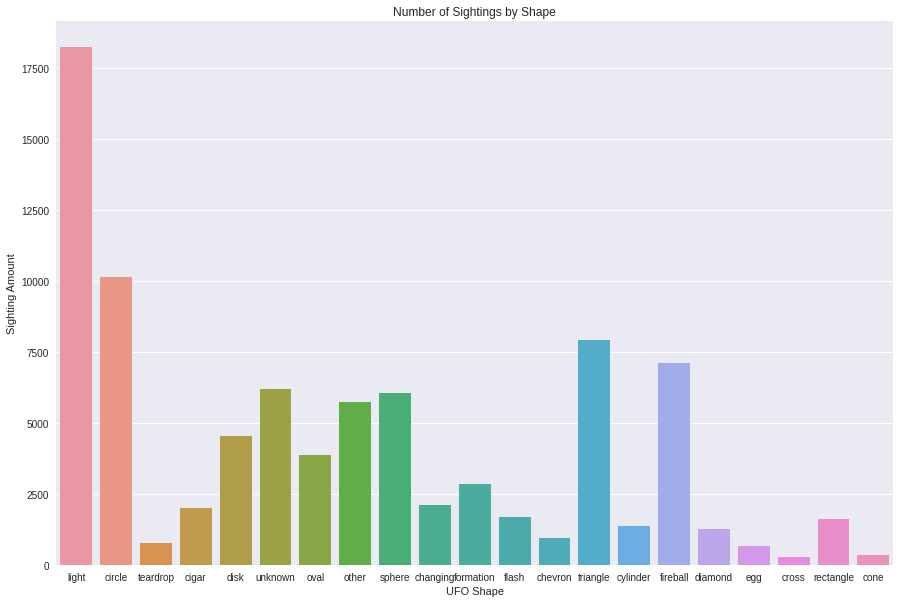

In [78]:
plt.figure(figsize=(15,10))
sns.countplot(data=df, x='shape')
plt.xlabel('UFO Shape')
plt.ylabel('Sighting Amount')
plt.title('Number of Sightings by Shape')

Text(0.5, 1.0, 'Number of Sightings by Month')

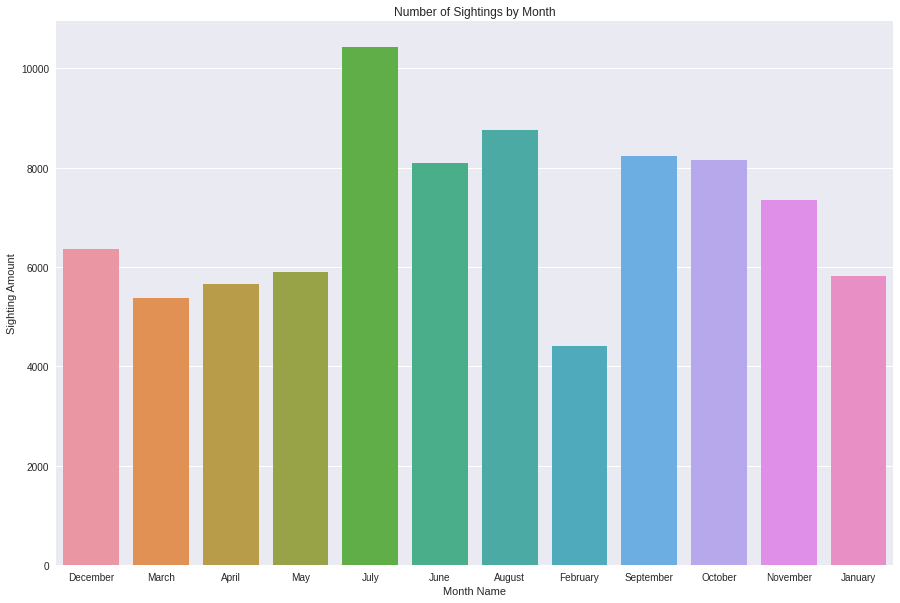

In [86]:
plt.figure(figsize=(15,10))
sns.countplot(data=df, x='month (name)')
plt.xlabel('Month Name')
plt.ylabel('Sighting Amount')
plt.title('Number of Sightings by Month')

Text(0, 0.5, 'Longitude')

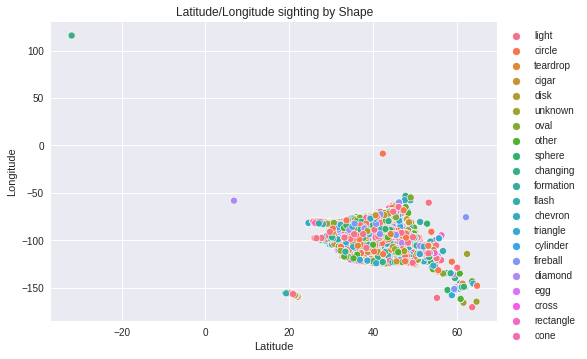

In [85]:
ax = sns.scatterplot(data=df, x='city_latitude', y='city_longitude', hue='shape')
ax.legend(bbox_to_anchor=[1,1]);

ax.set_title('Latitude/Longitude sighting by Shape')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')

## Model Selection

In [46]:
#creating a preprocessor 
X=df.drop(columns='shape')
y=df['shape']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [47]:
scaler = StandardScaler()
ohe= OneHotEncoder(handle_unknown='ignore')

freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [48]:
num_pipe = make_pipeline(mean_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

In [49]:
preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f894c376690>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f894c376250>)])

In [53]:
#initiate Decision Tree Model
dec_tree = DecisionTreeClassifier(random_state=42, max_depth=5)
dec_pipe = make_pipeline(preprocessor, dec_tree)
dec_pipe.fit(X_train, y_train)

train_pred = dec_pipe.predict(X_train)
test_pred = dec_pipe.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f'Train Score: {train_acc}')
print(f'Test Score: {test_acc}')

Train Score: 0.22025848645281842
Test Score: 0.21474284112673425


In [54]:
dec_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f894c376690>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f894c37

In [57]:
#using GridSearchCV to maximize parameters 
param_grid = {'decisiontreeclassifier__max_depth': range(1,10),
              'decisiontreeclassifier__min_samples_leaf': [1, 5, 10],
              'decisiontreeclassifier__min_samples_split': [2, 10, 100]}

dt_grid = GridSearchCV(dec_pipe, param_grid)
dt_grid.fit(X_train, y_train)

print('Training accuracy:', dt_grid.score(X_train, y_train))
print('Testing accuracy:', dt_grid.score(X_test, y_test))


Training accuracy: 0.2186857676736219
Testing accuracy: 0.21572382865417855


In [58]:
#initiate KNN model 
knn = KNeighborsClassifier()
knn_pipe = make_pipeline(preprocessor, knn)
knn_pipe.fit(X_train, y_train)

print('Training accuracy:', knn_pipe.score(X_train, y_train))
print('Testing accuracy:', knn_pipe.score(X_test, y_test))

Training accuracy: 0.3668016194331984
Testing accuracy: 0.13061148222544028


In [59]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f894c376690>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f894c37

In [63]:
k_param_grid = {'kneighborsclassifier__leaf_size': range(20,50),
              'kneighborsclassifier__n_neighbors': range(1,10),
              'kneighborsclassifier__p': range(2,8)}
knn_grid = GridSearchCV(knn_pipe, k_param_grid)
knn_grid.fit(X_train, y_train)


print('Training accuracy:', knn_grid.score(X_train, y_train))
print('Testing accuracy:', knn_grid.score(X_test, y_test))

KeyboardInterrupt: ignored

In [65]:
lg = LogisticRegression(C=1000)
lg_pipe = make_pipeline(preprocessor, lg)
lg_pipe.fit(X_train, y_train)


print('Training accuracy:', lg_pipe.score(X_train, y_train))
print('Testing accuracy:', lg_pipe.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training accuracy: 0.21594518841482405
Testing accuracy: 0.21278086607184565


While no model is performing particularly well, the KNN Model had done the best. If we wish to move forward, I will reccomend this one.